In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [0]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

In [0]:
# to improve accuracy
subtract_pixel_mean = True

In [5]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.002
    if epoch > 23:
        lr *= 1.5
    elif epoch > 30:
        lr *= 2
    elif epoch > 40:
        lr *= 2.5
    #elif epoch > 80:
    #    lr *= 0.005
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
# using resnet v1
model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.005),
              metrics=['accuracy'])
model.summary()
print(model_type)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 16)   64          conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_39[0][0]     
____________________________________________________________________________________________

In [16]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.5,
                               monitor='val_loss',
                               cooldown=0,
                               patience=3,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/50
1563/1563 [==============================] - 83s 53ms/step - loss: 1.7246 - acc: 0.4273 - val_loss: 1.4674 - val_acc: 0.5385

Epoch 00001: val_acc improved from -inf to 0.53850, saving model to /content/saved_models/cifar10_ResNet20v1_model.001.h5
Epoch 2/50
1563/1563 [==============================] - 77s 49ms/step - loss: 1.3704 - acc: 0.5865 - val_loss: 1.3765 - val_acc: 0.6094

Epoch 00002: val_acc improved from 0.53850 to 0.60940, saving model to /content/saved_models/cifar10_ResNet20v1_model.002.h5
Epoch 3/50
1563/1563 [==============================] - 78s 50ms/step - loss: 1.2222 - acc: 0.6507 - val_loss: 1.5401 - val_acc: 0.5704

Epoch 00003: val_acc did not improve from 0.60940
Epoch 4/50
1563/1563 [==============================] - 78s 50ms/step - loss: 1.1270 - acc: 0.6901 - val_loss: 1.4922 - val_acc: 0.6042

Epoch 00004: val_acc did not improve from 0.60940
Epoch 5/50
1563/1563 [==============================] - 77s 49ms/step 

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
images = {
    'airplane': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS4FRvfvQaXBo3h_EFIbJdu69_wMZ9QDmrvKmMTgqoMnF2U7fi_',
    'automobile': 'https://img.etimg.com/thumb/msid-72161888,width-1200,height-900/small-biz/startups/newsbuzz/heres-why-automobile-giants-are-offering-car-subscription-services-to-their-clients.jpg',
    'bird': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRxMEqTUgokmNgC3E2TKSECZUFFSNita61SUcWlwKUh0yByyEYC',
    'cat': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ6GgP6a1s-GoVIBoswBvWVp23OqVXGNi8vzJdf-zb7jzOFvtc4',
    'deer': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQLu0NPT36vpAej9B6DS3cRMOMCg-tNffLOq7YqsyuM8nxOB33T',
    'dog': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT-kC6_yR_0DJLOCkpzTMxpvi7DaqWleYJ6HdARaXIh-OXkvVdG',
    'frog': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRFet-8ChlUWkcAjSg_-DTRc8DcJNfkSyKbBF_vjTd29vqBNkBu',
    'horse': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQfyGt4r9cMnl7_CmK9YCO05Eq4Af_UDqLgC5KQcLaavBg7m1JW',
    'ship': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQjE_oAKOrTi299i2Ubz9DbrpgD6ZSD6ciDZPGcTuCXbOXXU-es',
    'truck': 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRh4eUS3UX-5NaPTZCu76XHeVmZZwBXWzygj_j-1z09aHdDfMkx'
}

In [0]:
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
from skimage import io
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import img_to_array

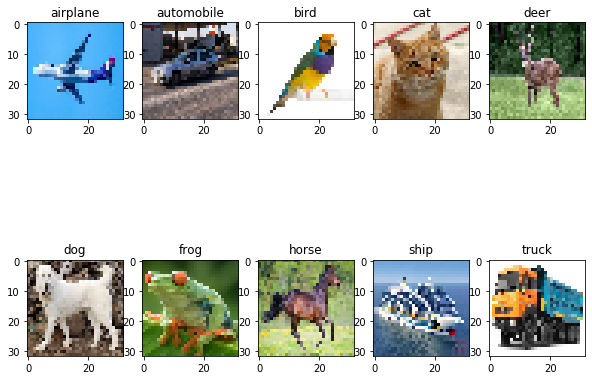

In [0]:
_, ax = plt.subplots(2, 5, figsize=(10, 8))
row_num, col_num = 2, 5

row, col = 0, 0 
for name, url in images.items():
    try:
        if col == 5:
            col = 0
            row += 1
        image = io.imread(url)
        image = cv2.resize(image, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
        ax[row][col].imshow(image)
        ax[row][col].set_title(name)
        col += 1

    except:
        print("image cant be loaded")

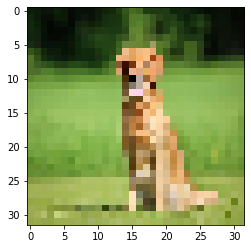

In [0]:
dog = io.imread("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTMemuqzvEIfg5E6vGDlkng3y5oXrk1-cJoPSRhSA6ENve_tMbk")
dog = cv2.resize(dog, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
plt.imshow(dog);

In [0]:
preds = model.predict(x); preds
class_idx = np.argmax(preds[0]);

5

In [0]:
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("add_27")

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

(?, 8, 8, 64)
(64,)


In [0]:
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(8, 8, 64)
(8, 8)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [0]:
heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)


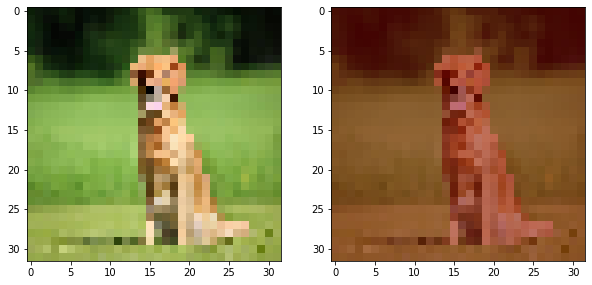

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)

ax[0][0].imshow(dog)
ax[0][1].imshow(superimposed_img);

In [0]:
def display_all_gradcam_images(class_names: list, actual_images: dict):
    _, ax = plt.subplots(4, 5, figsize=(20, 14))
    row, col = 0, 0 
    
    for name, url in actual_images.items():
        
        if col == 5:
            row += 2
            col = 0

        img = io.imread(url)
        img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # preprocess image
        x /= 255
        x -= x_train_mean

        preds = model.predict(x)
        class_idx = np.argmax(preds[0])
        predicted_class_name = class_names[class_idx]

        class_output = model.output[:, class_idx]
        last_conv_layer = model.get_layer("add_27")

        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]]) 

        pooled_grads_value, conv_layer_output_value = iterate([x])

        for i in range(64):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i] 

        heatmap = np.mean(conv_layer_output_value, axis = -1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

        ax[row][col].imshow(img);
        ax[row][col].set_title(f'Actual: {name}')

        ax[row+1][col].imshow(superimposed_img);
        ax[row+1][col].set_title(f'Predicted: {predicted_class_name}')

        col += 1

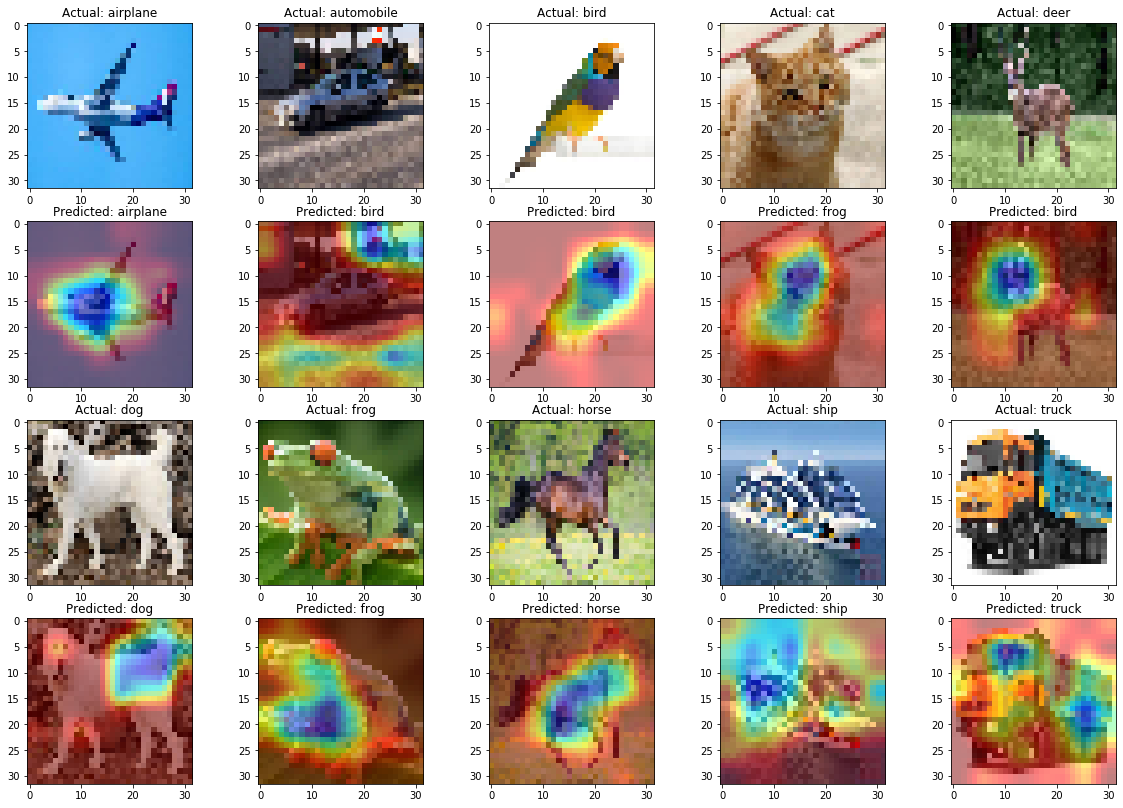

In [0]:
display_all_gradcam_images(class_names, images)